##  DonorsChoose- Part 1. Preprocessing & Feature Engineering

**<a href='#1'>1. Introduction</a><br>**
**<a href='#2'>2. Get Data</a><br>**
**<a href='#3'>3. Data Exploration: First look at the datasets </a><br>**
**<a href='#4'>4. Data Cleaning </a><br>**
**<a href='#5'>5. Feature Engineering </a><br>**
<a href='#5.1'>5.1 Adding Geocoding Data using Google MAP API</a><br>
<a href='#5.2'>5.2 Split Dataset according to Validation Scheme</a><br>
<a href='#5.3'>5.3 Design Project Features Matrix and Donor Features Matrix</a><br>
<a href='#5.4'>5.4 Scale Donor Feature Matrix</a><br>
**<a href='#6. '>6.  Review the New Features </a><br>**

 ### <a id='1'>1. Introduction</a>

DonorsChoose.org is an organization that helps teachers fundraise for American classrooms. The organization has funded over 1.1 million classroom requests through the support of 3 million donors, the majority of whom were making their first-ever donation to a public school. If DonorsChoose.org can motivate even a fraction of those donors to make another donation, that could have a huge impact on the number of classroom requests fulfilled.  The goal of the project is to enable DonorsChoose.org to build targeted email campaigns, recommending specific classroom requests to prior donors.   <br>

The organization has supplied anonymized [data](https://www.kaggle.com/donorschoose/io) on donor giving from the past five years, starting from January 2013 to May 1, 2018.  Six data files are provided with the following dimensions:
* donations (4687884, 10)
* donors (2122640, 5)
* projects (1110017, 15)
* resources (7210448, 4)
* schools (72993, 9)
* teachers (402900, 3)

This notebook is Part 1 of 3 notebooks.  Part 1 focuses on Feature Engineering, Part 2 focuses on Data Exploration, and Part 3 focuss on building the recommender system and evaluating the model.  

This notebook will focus on pre-processing and feature engineering.  The main approach for this project is to recommend projects based on donor's previous donation characteristics, as well as project characteristics.  In this notebook, we will do the following:
1.  Obtain longitude and latitude data for the donor's and project's locations and calculate distance between each donor and project.  
2. Create Project Features Matrix that describes each projects using 71 dimensions from one-hot encoding features from project descriptions and school descriptions.  
3. The Donor Features Matrix will be a feature matrix that reflects the donor's preferences using 96 dimensions.  We want to assess if donor has preference to location, project type, resource type, grade level, schools with more underpreviledged kids (measured by % of students receiving free lunch).  In addition, we will use donor's previous donation history to generate new features.    
4. The Donor Features will then be normalized by subtracting out the mean of all donors.

To validate the recommender model, data prior to 2018 will be used to generate donor profile, and  donations in January 2018  will be used to check for effectiveness of the recommendation system.  

Below are the version of the Python packages utilized:
* numpy 1.14.0
* pandas 0.22.0
* requests 2.18.4
* sklearn 0.19.1
* seaborn 0.8.1
* matplotlib 2.1.2
* plotly 2.7.0



 ### <a id='2'>2. Get Data</a>

In [4]:
import numpy as np
import pandas as pd 
import os
import requests
import datetime as dt
import pickle
import gc
from math import sin, cos, sqrt, atan2, radians
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.offline.init_notebook_mode(connected=True)
%matplotlib inline

Set data paths

In [2]:
print(os.listdir("./data"))
cwd = os.getcwd()
data_folder = 'data'

['Donations.csv', 'Donors.csv', 'mappingFinal_all.csv', 'mappingFinal_all_modified.csv', 'Projects.csv', 'Resources.csv', 'Schools.csv', 'Teachers.csv', 'zipMapping.csv']


In [3]:
# The projects dataset has text columns with project descriptions. Exclude these to save memory. 
projectCols = ['Project ID', 'School ID', 'Teacher ID',
               'Teacher Project Posted Sequence', 'Project Type',
               'Project Subject Category Tree', 'Project Subject Subcategory Tree',
               'Project Grade Level Category', 'Project Resource Category',
               'Project Cost', 'Project Posted Date', 'Project Expiration Date',
               'Project Current Status', 'Project Fully Funded Date']

resourcesCols = ['Project ID','Resource Quantity','Resource Unit Price', 'Resource Vendor Name']

In [4]:
donations = pd.read_csv(os.path.join(cwd, data_folder, 'Donations.csv'), 
                        dtype = {'Donation Amount': np.float32, 'Donor Cart Sequence': np.int32})
donors = pd.read_csv(os.path.join(cwd, data_folder, 'Donors.csv'),
                                 dtype = {'Donor Zip':'str'})
projects = pd.read_csv(os.path.join(cwd, data_folder, 'Projects.csv'), 
                       usecols = projectCols, 
                      dtype = {'Teacher Project Posted Sequence': np.float32, 'Project Cost': np.float32})
resources = pd.read_csv(os.path.join(cwd, data_folder, 'Resources.csv'), 
                        usecols = resourcesCols,
                       dtype = {'Resource Quantity': np.float32,'Resource Unit Price': np.float32})
schools = pd.read_csv(os.path.join(cwd, data_folder, 'Schools.csv'), dtype = {'School Zip': 'str'})
teachers = pd.read_csv(os.path.join(cwd, data_folder, 'Teachers.csv'))

Cast to appropriate data types for each dataframe.

In [5]:
# donations
donations['Donation Received Date'] = pd.to_datetime(donations['Donation Received Date'])
donations['Donation Included Optional Donation'].replace(('Yes', 'No'), (1, 0), inplace=True)
donations['Donation Included Optional Donation'] = donations['Donation Included Optional Donation'].astype('bool')
donations['Donation_Received_Year'] = donations['Donation Received Date'].dt.year
donations['Donation_Received_Month'] = donations['Donation Received Date'].dt.month
donations['Donation_Received_Day'] = donations['Donation Received Date'].dt.day

# donors
donors['Donor Is Teacher'].replace(('Yes', 'No'), (1, 0), inplace=True)
donors['Donor Is Teacher'] = donors['Donor Is Teacher'].astype('bool')

# projects
cols = ['Project Posted Date', 'Project Fully Funded Date']
projects.loc[:, cols] = projects.loc[:, cols].apply(pd.to_datetime)
projects['Days_to_Fullyfunded'] = projects['Project Fully Funded Date'] - projects['Project Posted Date']

# teachers
teachers['Teacher First Project Posted Date'] = pd.to_datetime(teachers['Teacher First Project Posted Date'])

Name the dataframes.

In [6]:
def name_dataframes(dfList, dfNames):
    '''
    give names to a list of dataframes. 
    Argument:
        dfList = list of dataframes,
        dfNames = list of names for the dataframes
    Return:
        None
    '''
    for df, name in zip(dfList, dfNames):
        df.name = name
    
    return

In [7]:
dfList = [donations, donors, projects, resources, schools, teachers]
dfNames = ['donations', 'donors', 'projects', 'resources', 'schools', 'teachers']
name_dataframes(dfList, dfNames)

### <a id='3'>3. Data Exploration:  First look at the datasets</a>

#### Shape of dataframes

In [8]:
# print shapes of dataframes
for df in dfList:
    print(df.name, df.shape)

donations (4687884, 10)
donors (2122640, 5)
projects (1110017, 15)
resources (7210448, 4)
schools (72993, 9)
teachers (402900, 3)


#### Columns of dataframes

In [9]:
# print column names of dataframes
for df in dfList:
    print(df.name + ":\n" , df.columns)

donations:
 Index(['Project ID', 'Donation ID', 'Donor ID',
       'Donation Included Optional Donation', 'Donation Amount',
       'Donor Cart Sequence', 'Donation Received Date',
       'Donation_Received_Year', 'Donation_Received_Month',
       'Donation_Received_Day'],
      dtype='object')
donors:
 Index(['Donor ID', 'Donor City', 'Donor State', 'Donor Is Teacher',
       'Donor Zip'],
      dtype='object')
projects:
 Index(['Project ID', 'School ID', 'Teacher ID',
       'Teacher Project Posted Sequence', 'Project Type',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Posted Date', 'Project Expiration Date',
       'Project Current Status', 'Project Fully Funded Date',
       'Days_to_Fullyfunded'],
      dtype='object')
resources:
 Index(['Project ID', 'Resource Quantity', 'Resource Unit Price',
       'Resource Vendor Name'],
      dtype='object')
scho

#### Summary of dataframes

In [10]:
def data_summary(df):
    '''print out information about dataframe
    Argument: dataframe name
    Return: dataframe with summary figures
    '''
    temp = pd.DataFrame(data = df.isnull().sum(axis=0))
    temp.columns=['NA count']
    temp['NA %'] = temp['NA count']/(df.shape[0])*100
    temp['# unique vals'] = df.nunique(axis=0)
    temp['dtype'] =  df.dtypes
    temp['dataset'] = df.name
    
    return temp


#### Donations

In [11]:
donations.head(2)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Donation_Received_Year,Donation_Received_Month,Donation_Received_Day
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,False,178.369995,11,2016-08-23 13:15:57,2016,8,23
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,True,25.000000,2,2016-06-06 20:05:23,2016,6,6


In [12]:
data_summary(donations)

,NA count,NA %,# unique vals,dtype,dataset
Project ID,0,0.0,901965,object,donations
Donation ID,0,0.0,4687844,object,donations
Donor ID,0,0.0,2024554,object,donations
Donation Included Optional Donation,0,0.0,2,bool,donations
Donation Amount,0,0.0,76192,float32,donations
Donor Cart Sequence,0,0.0,18071,int32,donations
Donation Received Date,0,0.0,4066370,datetime64[ns],donations
Donation_Received_Year,0,0.0,7,int64,donations
Donation_Received_Month,0,0.0,12,int64,donations
Donation_Received_Day,0,0.0,31,int64,donations


#### Donors

In [13]:
donors.head(2)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,False,602
1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,False,245


In [14]:
data_summary(donors)

,NA count,NA %,# unique vals,dtype,dataset
Donor ID,0,0.000000,2122640,object,donors
Donor City,213097,10.039244,15204,object,donors
Donor State,0,0.000000,52,object,donors
Donor Is Teacher,0,0.000000,2,bool,donors
Donor Zip,180060,8.482833,1065,object,donors


#### Projects

In [15]:
projects.head(2)

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date,Days_to_Fullyfunded
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25.0,Teacher-Led,Applied Learning,"Character Education, Early Development",Grades PreK-2,Technology,361.799988,2013-01-01,2013-05-30,Fully Funded,2013-01-11,10 days
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3.0,Teacher-Led,"Applied Learning, Literacy & Language","Early Development, Literacy",Grades PreK-2,Technology,512.849976,2013-01-01,2013-05-31,Expired,NaT,NaT


In [16]:
data_summary(projects)

,NA count,NA %,# unique vals,dtype,dataset
Project ID,0,0.000000,1110015,object,projects
School ID,0,0.000000,72361,object,projects
Teacher ID,0,0.000000,395706,object,projects
Teacher Project Posted Sequence,0,0.000000,488,float32,projects
Project Type,0,0.000000,3,object,projects
Project Subject Category Tree,29,0.002613,51,object,projects
Project Subject Subcategory Tree,29,0.002613,432,object,projects
Project Grade Level Category,0,0.000000,5,object,projects
Project Resource Category,36,0.003243,17,object,projects
Project Cost,0,0.000000,163023,float32,projects


#### Resources

In [17]:
resources.head(2)

,Project ID,Resource Quantity,Resource Unit Price,Resource Vendor Name
0,000009891526c0ade7180f8423792063,1.0,350.00,NaN
1,00000ce845c00cbf0686c992fc369df4,40.0,12.86,CDW-G


In [18]:
data_summary(resources)

,NA count,NA %,# unique vals,dtype,dataset
Project ID,0,0.000000,1208649,object,resources
Resource Quantity,24299,0.336997,341,float32,resources
Resource Unit Price,24310,0.337150,50253,float32,resources
Resource Vendor Name,81994,1.137155,31,object,resources


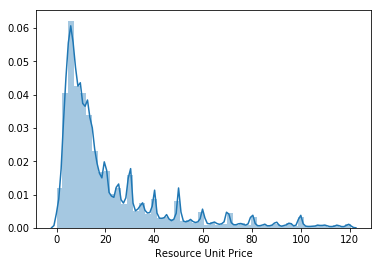

In [19]:
data = resources.loc[resources['Resource Unit Price'] < resources['Resource Unit Price'].quantile(0.90)]['Resource Unit Price']
sns.distplot(data)

#### Schools

In [20]:
schools.head(2)

,School ID,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
0,00003e0fdd601b8ea0a6eb44057b9c5e,Capon Bridge Middle School,rural,56.0,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District
1,00004e32a448b4832e1b993500bf0731,The Woodlands College Park High School,urban,41.0,Texas,77384,The Woodlands,Montgomery,Conroe Ind School District


In [21]:
data_summary(schools)

,NA count,NA %,# unique vals,dtype,dataset
School ID,0,0.000000,72993,object,schools
School Name,0,0.000000,56831,object,schools
School Metro Type,0,0.000000,5,object,schools
School Percentage Free Lunch,1141,1.563164,101,float64,schools
School State,0,0.000000,51,object,schools
School Zip,0,0.000000,19010,object,schools
School City,227,0.310989,10400,object,schools
School County,2,0.002740,1782,object,schools
School District,0,0.000000,10852,object,schools


#### Teachers

In [22]:
teachers.head(2)

,Teacher ID,Teacher Prefix,Teacher First Project Posted Date
0,00000f7264c27ba6fea0c837ed6aa0aa,Mrs.,2013-08-21
1,00002d44003ed46b066607c5455a999a,Mrs.,2016-10-23


In [23]:
data_summary(teachers)

,NA count,NA %,# unique vals,dtype,dataset
Teacher ID,0,0.00000,402900,object,teachers
Teacher Prefix,28,0.00695,6,object,teachers
Teacher First Project Posted Date,0,0.00000,4699,datetime64[ns],teachers


### <a id='4'>4. Data Cleaning: Remove rows in the datasets that cannot be mapped </a>

In [24]:
projects = projects.loc[projects['School ID'].isin(schools['School ID'])]
projects = projects.loc[projects['Project ID'].isin(resources['Project ID'])]
donations = donations.loc[donations['Project ID'].isin(projects['Project ID'])]
donations = donations.loc[donations['Donor ID'].isin(donors['Donor ID'])]
donors = donors.loc[donors['Donor ID'].isin(donations['Donor ID'])]

### <a id='5'>5. Feature Engineering</a>

#### <a id='5.1'>5.1 Adding Geocoding Data using Google MAP API</a>

#### Define function to get geocoding data from Goolge Maps API.

In [25]:
def geocode_address(addressList, key):
    '''
    The function takes a list of address and return a dataframe with geocoding information. 
    The most imporant column is "fullgeocode" which contains the output from Google Map API.
    
    Argument: a list of address, API key.  
    Return: a dataframe and two files: 'mappingFinal_{}.csv, 'citiesMappingFinal_{}.pkl'
    
    The neighborhood, country, and state should be used with caution depending on the order of returned json results.
    '''
    
    # create dataframe to store geo-coding data
    mapping = pd.DataFrame(columns = ['address', 'latitude', 'longitude', 'neighborhood', 'county', 'state', 'fullgeocode'])
    counter = -1
    
    # submit API calls and save output to mapping
    for address in addressList:
        
        # save every 500 queries
        counter+=1
        if counter == 500:
            now = dt.datetime.now().microsecond
            pd.DataFrame(mapping).to_csv('mapping_{}.csv'.format(now, encoding='utf8'))
            mapping.to_pickle('citiesMapping_{}.pkl'.format(now, encoding='utf8'))
            counter = -1
            print(len(mapping))
   
        # format query url
        url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(address, key)
        response = requests.get(url)
        
        # quit loop if response code is not okay (200)
        if response.status_code != 200:
            # print error
            print('error:', response.json())
            
            # save a copy of most recent data before break
            now = dt.datetime.now().microsecond
            pd.DataFrame(mapping).to_csv('mapping_{}.csv'.format(now, encoding='utf8'))
            mapping.to_pickle('citiesMapping_{}'.format(now, encoding='utf8'))
            
            break
        
        # continue if result is okay
        else:
            try:
                # extract data from json
                address = address
                latitude = response.json()['results'][0].get('geometry').get('location').get('lat')
                longitude = response.json()['results'][0].get('geometry').get('location').get('lng')
                neighborhood = response.json()['results'][0].get('address_components')[1].get('long_name')
                county = response.json()['results'][0].get('address_components')[2].get('long_name')
                state = response.json()['results'][0].get('address_components')[3].get('long_name')
                fullgeocode = response.json()['results']
            
                # append data to dataframe
                mapping.loc[len(mapping)] = [address, latitude, longitude, neighborhood, county, state, fullgeocode]
        
            except:
                next
    
    # save final copy as csv file
    now = dt.datetime.now().microsecond
    pd.DataFrame(mapping).to_csv('mappingFinal_{}.csv'.format(now, encoding='utf8'))
    mapping.to_pickle('citiesMappingFinal_{}.pkl'.format(now, encoding='utf8'))

    return fullgeocode

def geocode_zip(zipCodeList, apiKey):
    '''
    Input a list of zipcode and API Key and return geocoding information using Google API
    
    Arguments: A list of zipcodes and API key
    Returns: a dataframe with geocoding information
    '''
    
    # create dataframe to store geo-coding data
    mapping = pd.DataFrame(columns = ['zipcode', 'latitude', 'longitude', 'neighborhood', 'county', 'state'])
    
    # submit API calls and save output to mapping
    for zip in zipCodeList:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(zip, apiKey)
        response = requests.get(url)
        zipcode = zip
        
        try:
            # extract data from json
            latitude = response.json()['results'][0].get('geometry').get('location').get('lat')
            longitude = response.json()['results'][0].get('geometry').get('location').get('lng')
            neighborhood = response.json()['results'][0].get('address_components')[1].get('long_name')
            county = response.json()['results'][0].get('address_components')[2].get('long_name')
            state = response.json()['results'][0].get('address_components')[3].get('long_name')
            # append data to dataframe
            mapping.loc[len(mapping)] = [zipcode, latitude, longitude, neighborhood, county, state]
        
        except:
            next
    
    # save a copy as csv file
    pd.DataFrame(mapping).to_csv('mapping_{}.csv'.format(dt.datetime.now().microsecond), encoding='utf8')
    
    return mapping


#### Run function to get geocoding data for the "donors" and "schools" datasets.

Compile list of addresses to query by getting a list of cities, state for the "donors" and "schools" datasets.  Doing this hopefully will reduce the number of queries sent to the Google MAP API.

In [26]:
donorCities = donors['Donor City'].map(str)+', '+donors['Donor State']+', USA'
schoolCities = schools['School City'].map(str)+', '+schools['School State']+', USA'
cities = list(set(donorCities).union(set(schoolCities)))
cities = sorted(cities)
print('# of cities in donor:', len(set(donorCities)))
print('# of cities in schools:', len(set(schoolCities)))
print("# of cities for query:", len(cities))

# of cities in donor: 37937
# of cities in schools: 15084
# of cities for query: 40055


In [27]:
key = 'enter key here'

In [28]:
#mapping = geocode_address(cities, key)

In [29]:
mapping = pd.read_csv(os.path.join(cwd, data_folder, 'mappingFinal_all.csv'))

####  Parse city, state, country, from the fullgeocode column of the mapping file.

In [30]:
def parse_geocode(mapping):
    mapping['add_1']= mapping['fullgeocode'].str.extract('formatted_address\'[^\"]+\"([^\"]+)', expand=True)
    mapping['add_2']= mapping['fullgeocode'].str.extract('formatted_address\'[^\']+\'([^\']+)', expand=True)
    mapping['add_zip']= mapping['fullgeocode'].str.extract('\w\w\s(\d{5})', expand=True)
    reg = "long_name': '[a-zA-Z ]+', 'short_name': '([a-zA-Z ]+)', 'types': \['administrative_area_level_1', 'political'\]"
    mapping['add_state_short']= mapping['fullgeocode'].str.extract(reg, expand = True)
    reg = "long_name': '([a-zA-Z ]+)', 'short_name': '[a-zA-Z ]+', 'types': \['administrative_area_level_1', 'political'\]"
    mapping['add_state']= mapping['fullgeocode'].str.extract(reg, expand = True)
    reg = "'long_name': '([a-zA-Z ]+County)'"
    mapping['add_county']= mapping['fullgeocode'].str.extract(reg, expand = True)
    reg = "long_name': '([a-zA-Z ]+)', 'short_name': '[a-zA-Z ]+', 'types': \['locality', 'political'\]"
    mapping['add_city']= mapping['fullgeocode'].str.extract(reg, expand = True)
    reg = "long_name': '([a-zA-Z. ]+)', 'short_name': '[a-zA-Z ]+', 'types': \['country', 'political'\]"
    mapping['add_ctry']= mapping['fullgeocode'].str.extract(reg, expand = True)
    
    #### Revise the mapping file's neighborhood, coutry, state columns 
    mapping['neighborhood'] = mapping['add_city']
    mapping['county'] = mapping['add_county']
    mapping['state'] = mapping['add_state']
    
    #### Keep copy of the search City and search State
    mapping['search_state'] = mapping['address'].str.split(', ', expand = True)[1]
    states = list(mapping['search_state'].unique())
    states.remove('other')
    mapping['search_city'] = mapping['address'].str.split(',', expand = True)[0]
    
    return mapping

In [31]:
mapping = parse_geocode(mapping)

#### Flag questionable query results
The Donor City, Donor State in the "Donors" dataset has many incomplete or incorrect data.   Google API will still return a result irregardless of bazaar queries.  Therefore it is important that we flag the entries where the city/state we parsed from the geocoding data does not match the "Donor City" ,"Donor State".  

In [32]:
mapping.loc[mapping['state'] != mapping['search_state'], 'state_mismatch'] = 1
mapping.loc[mapping['neighborhood'] != mapping['search_city'], 'city_mismatch'] = 1
mapping.loc[(mapping['state_mismatch'].isnull()) & (mapping['city_mismatch'].isnull()), 'no_mismatch'] = 1
mapping.loc[(mapping['state_mismatch'].notnull()) & (mapping['city_mismatch'].notnull()), 'both_mismatch'] = 1

In [33]:
print('No mismatches in city and state names: {0:.2f}%'.format(mapping.no_mismatch.sum()/len(mapping)*100))
print('Mismatches in city names: {0:.2f}%'.format(mapping.city_mismatch.sum()/len(mapping)*100))
print('Mismatches in state names: {0:.2f}%'.format(mapping.state_mismatch.sum()/len(mapping)*100))
print('Both city and state are mismatched: {0:.2f}%'.format(mapping.both_mismatch.sum()/len(mapping)*100))

No mismatches in city and state names: 58.02%
Mismatches in city names: 27.96%
Mismatches in state names: 21.65%
Both city and state are mismatched: 7.63%


In [34]:
#mapping.to_pickle('mapping.pkl')

#### Merge mapping data with dataframes donors and schools.

In [35]:
cols = ['address', 'latitude','longitude','neighborhood', 'county', 'state', 'state_mismatch', 'city_mismatch', 'no_mismatch', 'both_mismatch']

In [36]:
donors['mapIndex'] = donors['Donor City'].map(str)+', '+donors['Donor State']+', USA'
donors = donors.merge(mapping[cols], how = 'left', left_on= 'mapIndex', right_on = 'address')
donors = donors.drop(['address'], axis=1)
donors = donors.rename(columns = {'latitude':'Donor_Lat', 'longitude': 'Donor_Lon' })

In [37]:
schools['mapIndex'] = schools['School City'].map(str)+', '+schools['School State']+', USA'
schools = schools.merge(mapping[['address', 'longitude', 'latitude']], how = 'left', left_on= 'mapIndex', right_on = 'address')
schools = schools.drop(['address'], axis=1)
schools = schools.rename(columns = {'latitude':'School_Lat', 'longitude': 'School_Lon' })

Previously in the "First Look At Data" section,  we saw that there were schools that did not have "School City" associated with it.  However, there were no missing Zip Codes.  We will query the missing Longitude and Latitude data using School Zip.

In [38]:
zipCodes = schools[schools['School_Lat'].isnull()]['School Zip'].unique()

In [39]:
#zipMapping = geocode_zip(zipCodes,'API Key Here')
#zipMapping = pd.read_csv(os.path.join(cwd, data_folder, 'zipMapping.csv'))

#zipMapping.to_pickle('zipMapping.pkl') 
zipMapping = pd.read_pickle('zipMapping.pkl')


In [40]:
zipMapping['zipcode'] = zipMapping['zipcode'].astype('str')
schools['School Zip'] = schools['School Zip'].astype('str')

In [41]:
m = schools['School_Lat'].isnull() # index for missing rows
schools.loc[m,'School_Lat'] = schools.loc[m, 'School Zip'].map(zipMapping.set_index('zipcode').latitude)
schools.loc[m,'School_Lon'] = schools.loc[m, 'School Zip'].map(zipMapping.set_index('zipcode').longitude)

**Explanation of new features in Donors: <br>**
mapIndex: the query sent to Google Map API<br>
Don_Lat, Don_Lon: latitude and longitude from the query<br>
neighboorhood, county, state:  parsed from the geocoding column of "mapping"<br>
state_mismatch, city_mismatch, no_mismatch, both_mismatch: compare whether the parsed city/state is the same as "Donor City" & "Donor State"

In [42]:
schools.to_pickle('schools.pkl')
donors.to_pickle('donors.pkl')
projects.to_pickle('projects.pkl')
donations.to_pickle('donations.pkl')
resources.to_pickle('resources.pkl')
teachers.to_pickle('teachers.pkl')

### <a id='5.2'>5.2 Split Dataset according to Validation Scheme</a>

Use data prior to 2018 to generate donor profile, and use donations in January, 2018 to check for effectiveness of the recommendation system.

#### Test set will include donors who satisfies the following conditions:
1. Donated to more than 1 project 
2. Donated in 2018 and prior to 2018

In [43]:
donorID_2018 = donations[donations['Donation_Received_Year'] == 2018]['Donor ID'].unique()
donorID_prior_2018 = donations[donations['Donation_Received_Year'] < 2018]['Donor ID'].unique()
test_ID = list(set(donorID_2018).intersection(donorID_prior_2018))
donations_prior = donations[(donations['Donor ID'].isin(test_ID)) & (donations['Donation_Received_Year'] < 2018)]
donations_2018 = donations[(donations['Donor ID'].isin(test_ID)) & (donations['Donation_Received_Year'] == 2018)]
del donorID_2018, donorID_prior_2018

### <a id='5.3'>5.3 Design Project Features Matrix and Donor Features Matrix</a>
The Project Features Matrix will decompose a project into multiple dimensions.

The Donor Features Matrix will be a feature matrix that reflects the donor's preferences.  We want to assess if donor has preference to location, project type, resource type, grade level, schools with more underpreviledged kids (measured by % of students receiving free lunch).  In addition, we will use donor's previous donation history as a part of dimensions that describes a donor.  

We will take the following steps to measure donor interests according to their project preferences, location preferences, & school preferences:
1. Devise a one-hot encoding of interest categories.  If the project falls under the interest category, it will have value of 1.
2. Obtain the dollar amount that each donor donates to each categories.
3. Calculate the percentage of dollar amount that goes to each category for each donor
4. Normalize interest of each donor by subtracting out the mean of all donors in each categories.

###   <font color='purple'> Create Project Features Matrix </font>
Create features to describe projects by one-hot encoding features from projects and schools

##### Merge Project with School

In [44]:
# fill NA for schools
schools['School Percentage Free Lunch'] = schools['School Percentage Free Lunch'].fillna(schools['School Percentage Free Lunch'].median()) #61%
projects = projects.dropna(axis = 0, subset = ['Project Subject Category Tree','Project Subject Subcategory Tree', 'Project Resource Category'])
projects = projects.merge(schools, on = 'School ID', how = 'left')

##### Create one-hot encoded feature matrix for the projects that uses data from the "project" and "schools" dataset

In [45]:
cols = ['Project Type', 'School Metro Type', 'Project Grade Level Category', 'Project Resource Category']
projFeatures_a = pd.get_dummies(projects[cols], prefix = cols)

##### Bin the school percentage free lunch into quintiles.

In [46]:
schoolStatus = pd.qcut(projects['School Percentage Free Lunch'], 5, labels=["rich", "upper-mid", "mid", "lower-mid", "poor"])
projFeatures_b = pd.get_dummies(schoolStatus, prefix = 'lunchAid')

##### Simplify representation of project categories

Define a new column from the "Projects" datasets called "all_subjects" by joining 'Project Subject Category Tree' and 'Project Subject Subcategory Tree'. If the term of interest is in 'all_subjects', it will have value of 1.

In [47]:
categories = ['Applied Learning', 'Literacy & Language', 'Special Needs',
       'Math & Science', 'History & Civics', 'Health & Sports',
       'Music & The Arts','Warmth, Care & Hunger']
subCategories = ['Character Education', 'Early Development', 'ESL', 'Special Needs',
       'Literacy', 'College & Career Prep', 'Mathematics', 'Economics',
       'Health & Wellness', 'Environmental Science', 'Applied Sciences',
       'Literature & Writing', 'Health & Life Science', 'Music', 'Other',
       'Foreign Languages', 'Gym & Fitness', 'History & Geography',
       'Civics & Government', 'Visual Arts', 'Community Service',
       'Performing Arts', 'Social Sciences', 'Extracurricular',
       'Team Sports', 'Nutrition Education', 'Parent Involvement',
       'Financial Literacy', 'Warmth, Care & Hunger']
all_cats = list(set(categories).union(set(subCategories)))
all_cats.sort()
#print(all_cats)
print('# of categories:', len(all_cats))

# compress the two project category into a single one
projects['all_subjects'] = projects['Project Subject Category Tree']+', '+projects['Project Subject Subcategory Tree']

# Search stream-lined category in the compressed categories
projFeatures_c = pd.DataFrame()
for cat in all_cats:
    projFeatures_c['ProjCat_'+cat] = projects['all_subjects'].str.contains(cat)
# save
projFeatures_c = projFeatures_c.astype(np.float32)

# of categories: 35


##### Join the project features matrices created above.

In [48]:
projFeatures =  projFeatures_a.join(projFeatures_b).join(projFeatures_c)
projFeatures['Project ID'] = projects['Project ID']
projFeatures.shape

(1109967, 71)

In [49]:
projFeatures.to_pickle('projFeatures.pkl') 
#projFeatures = pd.read_pickle('projFeatures.pkl')

###   <font color='purple'> Create features to reflect Donor's preferences in school location</font> 

##### Get distance between for each donor/project pair

Define function to calculate distance between two coordinates.

In [50]:
def distance(lat1, lat2, lon1, lon2):
    """
    Calculate the Haversine distance in miles.
    """
    radius = 6371  # km

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = (sin(dlat / 2) * sin(dlat / 2) +
         cos(radians(lat1)) * cos(radians(lat2)) *
         sin(dlon / 2) * sin(dlon / 2))
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    d = radius * c
    d = d/1.60934 # convert to miles
    
    return d

##### Calculate distance for donor-project pairs

In [51]:
# get all the donor-project combinations
dist = donations[['Project ID', 'Donor ID']].merge(projects[['Project ID', 'School_Lon', 'School_Lat']], on = 'Project ID', how = 'left')
dist = dist.merge(donors[['Donor ID', 'Donor_Lat', 'Donor_Lon',  'state_mismatch', 'city_mismatch', 'no_mismatch', 'both_mismatch']], on = 'Donor ID', how = 'left')
dist = dist.drop_duplicates(subset=['Project ID', 'Donor ID'], keep='first')

# calculate distance only for pairs that have valid address
dist = dist.loc[dist['no_mismatch'] == 1]

# narrow-down calculation to distinct lon_lat pairs
toCalc = dist.drop_duplicates(subset=['School_Lon', 'School_Lat', 'Donor_Lon', 'Donor_Lat'], keep='first')

# calculate distance
toCalc['dist'] = toCalc.apply(lambda x: distance(x['Donor_Lat'], x['School_Lat'], x['Donor_Lon'], x['School_Lon']), axis = 1)

# merge back to dist
cols = ['School_Lon', 'School_Lat', 'Donor_Lat', 'Donor_Lon', 'dist']
cols_b = ['School_Lon', 'School_Lat', 'Donor_Lat', 'Donor_Lon']
dist = dist.merge(toCalc.filter(items = cols), left_on = cols_b, right_on = cols_b, how = 'left')

# remove rows with null distance calculation
dist = dist[dist['dist'].notnull()]

# Fill NA with 0 
cols = ['state_mismatch', 'city_mismatch', 'no_mismatch', 'both_mismatch']
dist.loc[:,cols] = dist.loc[:,cols].fillna(0)

##### Bin the distance for easier interpretation of the feature matrix.

In [52]:
dist['dist_cut'] = pd.cut(dist['dist'], bins = [-1, 0, 5, 10, 20, 50, 100, 15000], labels = ['0', '1-5', '6-10', '11-20', '21-50', '51-100', '>100'])

##### One-hot encode distance bins

In [53]:
Dist_Avg = dist.groupby('Donor ID')['dist'].mean() # Calculate average distance by Donor ID
distFeatures = pd.get_dummies(dist['dist_cut'], prefix = 'Dist')
distFeatures['Project ID'] = dist['Project ID']
distFeatures['Donor ID'] = dist['Donor ID']
distFeatures['dist'] = dist['dist'] 
distFeatures = distFeatures.drop_duplicates(subset=['Project ID', 'Donor ID'], keep='first')

In [54]:
dist.to_pickle('dist.pkl')
distFeatures.to_pickle('distFeatures.pkl') 
#Dist_Avg.to_pickle('Dist_Avg.pkl') 

In [55]:
#dist = pd.read_pickle('dist.pkl')
#distFeatures = pd.read_pickle('distFeatures.pkl')
#Dist_Avg = pd.read_pickle('Dist_Avg.pkl')

###   <font color='purple'> Create features to reflect donor's previous donation history</font> 

Features are added to reflect the donor's previous donation history:
1. Obtain number of projects, # of donations, and the max cart number for each donor
2. Summarize donation amount per donor (mean, median, sum, std)
3. Count the number of schools and number of teachers that a donor donated to
4. Design feature to capture the concentration of donation to schools.  <br>
This feature calculates the ratio between the maximum donation to a single school by total donation made by the donor.  A donor who have strong favoritism towards one school will have a higher ratio. <br>
Formula: max(donation grouped by school)/ total(donations made by donor)
5. Design feature to capture the concentration of donation to a teacher. <br>
This feature follows same reasoning as schools.  <br>
Formula: max(donation grouped by teacher)/ total(donations made by donor
6. Calculate the mean of "School % Free Lunch" that a donor donates to.  This feature caputures inclination for donating to either poor or rich schools.
7.  Calculate set of statistics for the distances between the donor's city v.s. the schools that the donor donates to including mean, median, std, min, max)


In [56]:
def donor_summary(donations, projects, dist):
    ''' 
    Generate features to refelect donor's previous donation history:
    'num_proj', 'num_donation', 'num_cart', 'donation_median',
    'donation_mean', 'donation_sum', 'donation_std', 'School ID_count',
    'Teacher ID_count', 'schoolConcentration', 'TeacherConcentration',
    'lunchAid_Avg', 'Dist_median', 'Dist_mean', 'Dist_std', 'Dist_min',
    'Dist_max', 'Dist_Unknown'
    '''
    donations = donations.set_index('Donor ID', drop = False)
    donorSummary = pd.DataFrame(donations['Donor ID']).drop_duplicates(keep = 'first') 
    
    #### Obtain number of projects, # of donations, and the max cart number for each  donor
    countProj = donations.groupby(donations.index).agg({'Project ID':'nunique','Donor Cart Sequence':'max', 'Donation ID':'count'})
    countProj.columns = ['num_proj', 'num_donation','num_cart']
    donorSummary  = donorSummary.merge(countProj, left_index = True,  right_index=True, how = 'left')
    
    #### Summarize donation amount per donor (mean, median, etc)
    donAmt = donations.loc[:,'Donation Amount'].groupby([donations.index]).agg(['median','mean','sum', 'std'])
    donAmt.columns = 'donation_' + donAmt.columns
    donorSummary  = donorSummary.merge(donAmt, left_index = True,  right_index=True, how = 'left')
    
    #### Count # of schools and # of teachers that a donor donates to
    school_teacher = donations[['Project ID', 'Donation Amount', 'Donor ID']].merge(projects[['Project ID', 'School ID', 'Teacher ID']], left_on = 'Project ID', right_on = 'Project ID', how = 'left')
    concentration = school_teacher.groupby('Donor ID').agg({'School ID':'nunique', 'Teacher ID':'nunique'})
    concentration.columns = concentration.columns + '_count'
    donorSummary  = donorSummary.merge(concentration, left_index = True,  right_index=True, how = 'left')
    
    #### Design feature to capture the concentration of donation to schools.
    #### feature that captures doners that donates to multiple schools, and not just have one favorite school
    schoolSum = school_teacher.groupby(['Donor ID', 'School ID'])['Donation Amount'].sum().reset_index(drop = False)
    schoolSum = schoolSum.groupby(['Donor ID'])['Donation Amount'].agg(['sum', 'max'])
    schoolSum['SchoolConcentration'] = schoolSum['max']/schoolSum['sum']
    donorSummary['schoolConcentration'] = schoolSum['SchoolConcentration']
    
    #### Design feature to capture the concentration of donation to a teacher.  
    TeacherSum = school_teacher.groupby(['Donor ID', 'Teacher ID'])['Donation Amount'].sum().reset_index(drop = False)
    TeacherSum = TeacherSum.groupby(['Donor ID'])['Donation Amount'].agg(['sum', 'max'])
    TeacherSum['TeacherConcentration'] = TeacherSum['max']/TeacherSum['sum']
    donorSummary['TeacherConcentration'] = TeacherSum['TeacherConcentration']
    
    #### Calculate the Average School % Free Lunch of the schools that a donor donates to
    lunchAid_Avg = donations[['Project ID', 'Donor ID']].merge(projects[['Project ID', 'School Percentage Free Lunch']], on = 'Project ID', how = 'left')
    lunchAid_Avg['School Percentage Free Lunch'] = lunchAid_Avg ['School Percentage Free Lunch'].fillna(lunchAid_Avg['School Percentage Free Lunch'].median()) 
    lunchAid_Avg = lunchAid_Avg.drop_duplicates(subset=['Project ID', 'Donor ID'], keep='first')
    lunchAid_Avg = lunchAid_Avg.groupby('Donor ID').mean()
    donorSummary = donorSummary.merge(lunchAid_Avg, left_index = True,  right_index=True, how = 'left')
    donorSummary = donorSummary.rename(columns = {'School Percentage Free Lunch':'lunchAid_Avg'})
    
    #### Merge with Average Distance that a Donor Donates to
    dist = dist.set_index(['Donor ID', 'Project ID'])
    donations = donations.set_index(['Donor ID', 'Project ID'])
    donations = donations.merge(dist.filter(items = ['dist']), left_index = True, right_index = True, how = 'left')
    donations = donations.reset_index()
    
    distSummary = donations.groupby('Donor ID')['dist'].agg(['median', 'mean', 'std', 'min','max'])
    distSummary.columns = ['Dist_median', 'Dist_mean','Dist_std','Dist_min', 'Dist_max']
    donorSummary  = donorSummary.merge(distSummary, left_index = True,  right_index = True , how = 'left')
    
    donorSummary['Dist_Unknown'] = donorSummary['Dist_median'].isnull() # Flag rows with missing average distance
    donorSummary['Dist_median']  = donorSummary['Dist_median'].fillna(donorSummary['Dist_median'].median()) 
    donorSummary['Dist_mean']  = donorSummary['Dist_mean'].fillna(donorSummary['Dist_mean'].median()) 
    donorSummary['Dist_std']  = donorSummary['Dist_std'].fillna(donorSummary['Dist_std'].median()) 
    donorSummary['Dist_min']  = donorSummary['Dist_min'].fillna(donorSummary['Dist_min'].median()) 
    donorSummary['Dist_max']  = donorSummary['Dist_max'].fillna(donorSummary['Dist_max'].median()) 
    
    return donorSummary

In [57]:
donorSummary = donor_summary(donations_prior, projects, dist)

In [58]:
donorSummary.to_pickle('donorSummary.pkl')

In [59]:
#donorSummary = pd.read_pickle('donorSummary.pkl')

###   <font color='purple'> Weigh the preferences of the donors</font> 

In [60]:
def donor_interest(donations, projFeatures, distFeatures):
    ####  Obtain the dollar amount that each donor donates to each project features
    
    #### Sum $ amount of donor's donation to each project
    donor_sum = donations[['Donor ID','Project ID','Donation Amount']].groupby(['Donor ID','Project ID'])['Donation Amount'].agg('sum')
    donor_sum = pd.DataFrame(data = donor_sum).reset_index()
    donor_sum = donor_sum.sort_values(by = 'Donor ID')
    
    ##### Merge donor_sum dataset with the projectFeatures dataset.
    allFeatures = donor_sum.merge(projFeatures, on = 'Project ID', how='left')
    
    #### Many donors donate to projects that are not in the projectFeatures.  Delete those rows from analysis.
    allFeatures = allFeatures.dropna(subset = ['Project Type_Professional Development'])
    
    ##### Add distFeatures to allFeatures.
    allFeatures = allFeatures.merge(distFeatures, on = ['Project ID', 'Donor ID'], how='left')
    
    # Fill missing distance data.
    # Spreadout between Dist 0 and 20 since about half of the donations are under 20 miles.
    allFeatures.loc[allFeatures['Dist_0'].isnull(),'Dist_0'] = 0.56
    allFeatures.loc[allFeatures['Dist_1-5'].isnull(),'Dist_1-5'] = 0.08
    allFeatures.loc[allFeatures['Dist_6-10'].isnull(),'Dist_6-10'] = 0.16
    allFeatures.loc[allFeatures['Dist_11-20'].isnull(),'Dist_11-20'] = 0.20
    allFeatures.loc[allFeatures['Dist_21-50'].isnull(),'Dist_21-50'] = 0
    allFeatures.loc[allFeatures['Dist_51-100'].isnull(),'Dist_51-100'] = 0
    allFeatures.loc[allFeatures['Dist_>100'].isnull(),'Dist_>100'] = 0
    
    ##### Multiply donation amount to each of the one-hot encoded categories for each donor.  
    x = allFeatures['Donation Amount']
    x = x.values.reshape(len(allFeatures), 1)  # reshape from (dim,) to (dim,1) for matrix multiplication (broadcasting)
    y = allFeatures.iloc[:,3:]
    donorInterest = np.multiply(x, y)
    donorInterest['Donor ID'] = allFeatures['Donor ID']
    
    ##### Get total amount of donation per donor
    #The ultimate goal is to get % of dollar breakdown invested in each broader catogry 
    #(Project Type, School Metro, Project Grade, etc).  Not all projects in the donations 
    #dataset are in the projects dataset, so some rows show all 0 (see index 5 below).  
    #Since there are no null values in Project Type, every known projects will have Project Type value, 
    #to get total donation per donor that is in the project list, we will sum the columns Project Type.  
    
    donorTotal = donorInterest['Project Type_Professional Development'] + donorInterest['Project Type_Student-Led'] + donorInterest['Project Type_Teacher-Led']
    donorTotal.index = donorInterest['Donor ID']
    donorTotal = donorTotal.groupby('Donor ID').sum()
    
    ##### Get total amount of donation per feature per donor
    donorInterest = donorInterest.groupby('Donor ID').sum()
    
    #### Step 3: Calculate the percentage of dollar amount that goes to each category for each donor
    donorInterest = donorInterest.div(donorTotal, axis=0)
    
    return donorInterest

In [61]:
donorInterest = donor_interest(donations_prior, projFeatures, distFeatures)

In [62]:
donorInterest.to_pickle('donorInterest.pkl')

In [63]:
#donorInterest = pd.read_pickle('donorInterest.pkl')

###   <font color='purple'> Finish creating Donor Feature Matrix </font> 
#### Merge Donor Interest (categorical attributes) with Donor Summary (donation history)

In [64]:
def Get_donorFeatureMatrixNoAdj(donorInterest, donorSummary):
    '''
    Merge donorInterest with donorSummary
    '''
    donorFeatureMatrix = donorInterest.merge(donorSummary, left_index = True, right_index = True, how = 'left')
    donorFeatureMatrix.loc[donorFeatureMatrix['donation_std'].isnull(), 'donation_std'] = 0 # set standard deviation of the single donation donors to 0
    
    return donorFeatureMatrix

In [65]:
donorFeatureMatrixNoAdj = Get_donorFeatureMatrixNoAdj(donorInterest, donorSummary)

In [66]:
donorFeatureMatrixNoAdj.to_pickle('donorFeatureMatrixNoAdj.pkl') # save a copy before any adjustments

### <a id='5.4'>5.4 Scale Donor Feature Matrix</a>

We will scale the donor feature matrix by subtracting out the mean preferences of all the donors from each donor for features related to projects (Project Type, grade, school metro type, etc): <br>
Formula: individual donor preference - mean(all donor's preferences)

For the dimensions related to donor's previous donation history (number of projects, number of donations, school concentration,  mean distance of donations, etc) we will scale by calculate the percentile ranking.

In [67]:
def scaleFeatureMatrix(donorFeatureMatrix):
    '''
    Measure preference of each donor by subtracting the mean
    Arguments: donorFeatureMatrix
    '''
    donorFeatureMatrix = donorFeatureMatrix.drop(['Donor ID'], axis=1)
    
    ### Subtract each column by mean
    donorMeanMatrix = (donorFeatureMatrix.loc[:,'Project Type_Professional Development': 'Dist_>100']).mean(axis = 0)
    donorFeatureMatrix.loc[:,'Project Type_Professional Development': 'Dist_>100'] = donorFeatureMatrix.loc[:,'Project Type_Professional Development': 'Dist_>100'] - donorMeanMatrix # make sure matrix does not include Donor ID, otherwise pandas try to convert string to float, (set Donor ID as index) (set Donor ID as index)
    
    #### Add Percentile Calculation
    cols =  ['num_proj', 'num_donation', 'num_cart', 'donation_median',
       'donation_mean', 'donation_sum', 'donation_std', 'School ID_count',
       'Teacher ID_count', 'schoolConcentration', 'TeacherConcentration',
       'lunchAid_Avg', 'Dist_median', 'Dist_mean', 'Dist_std', 'Dist_min',
       'Dist_max']
    
    donorPercentRank = ((donorFeatureMatrix.loc[:,cols]).rank(ascending = True))/len(donorFeatureMatrix)
    donorPercentRank.columns = 'Percentile_' + donorPercentRank.columns
    donorFeatureMatrix = donorFeatureMatrix.merge(donorPercentRank, left_index = True, right_index = True, how = 'left')
    donorFeatureMatrix = donorFeatureMatrix.drop(cols, axis=1)
    
    return donorFeatureMatrix

In [68]:
donorFeatureMatrix = scaleFeatureMatrix(donorFeatureMatrixNoAdj)

In [69]:
donorFeatureMatrix.to_pickle('donorFeatureMatrix.pkl') # with percentile 

In [70]:
#donorFeatureMatrix = pd.read_pickle('donorFeatureMatrix.pkl')

### <a id='6'>6. Review the New Features </a>

In [71]:
donorFeatureMatrix.shape

(81782, 96)

In [72]:
donorFeatureMatrix.columns

Index(['Project Type_Professional Development', 'Project Type_Student-Led',
       'Project Type_Teacher-Led', 'School Metro Type_rural',
       'School Metro Type_suburban', 'School Metro Type_town',
       'School Metro Type_unknown', 'School Metro Type_urban',
       'Project Grade Level Category_Grades 3-5',
       'Project Grade Level Category_Grades 6-8',
       'Project Grade Level Category_Grades 9-12',
       'Project Grade Level Category_Grades PreK-2',
       'Project Grade Level Category_unknown',
       'Project Resource Category_Art Supplies',
       'Project Resource Category_Books',
       'Project Resource Category_Classroom Basics',
       'Project Resource Category_Computers & Tablets',
       'Project Resource Category_Educational Kits & Games',
       'Project Resource Category_Flexible Seating',
       'Project Resource Category_Food, Clothing & Hygiene',
       'Project Resource Category_Instructional Technology',
       'Project Resource Category_Lab Equipment',

In [73]:
projFeatures.shape

(1109967, 71)

In [74]:
projFeatures.columns

Index(['Project Type_Professional Development', 'Project Type_Student-Led',
       'Project Type_Teacher-Led', 'School Metro Type_rural',
       'School Metro Type_suburban', 'School Metro Type_town',
       'School Metro Type_unknown', 'School Metro Type_urban',
       'Project Grade Level Category_Grades 3-5',
       'Project Grade Level Category_Grades 6-8',
       'Project Grade Level Category_Grades 9-12',
       'Project Grade Level Category_Grades PreK-2',
       'Project Grade Level Category_unknown',
       'Project Resource Category_Art Supplies',
       'Project Resource Category_Books',
       'Project Resource Category_Classroom Basics',
       'Project Resource Category_Computers & Tablets',
       'Project Resource Category_Educational Kits & Games',
       'Project Resource Category_Flexible Seating',
       'Project Resource Category_Food, Clothing & Hygiene',
       'Project Resource Category_Instructional Technology',
       'Project Resource Category_Lab Equipment',